In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import numpy as np
import math
import random 
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import os


# In[2]:


def coordinates_on_circle(n):
    """Returns x,y coordinates of points on an unit circle with spacing 2π/n"""
    if type(n)!=int:
        raise Exception("Wrong input: \n the argument must be an integer number of points on the unit circle!")
    x,y = [],[]
    step_angle = 2*math.pi/n
    for i in range(0,n):
        x.insert(len(x),math.cos(i*step_angle))
        y.insert(len(y),math.sin(i*step_angle))
    return x,y


# In[3]:


def create_starting_graph(n,r):
    if type(r)!=int:
        raise Exception("Wrong input: \n r must be an integer number of edges between vertices")
    if r>n-1:
        raise Exception("Wrong input: \n r must not exceed n-1!")
    coords = coordinates_on_circle(n)
    
    #create adjacency_matrix as pandas df
    #Initialize adjacency matrix
    adj_mat_df = pd.DataFrame(np.zeros([n,n]),dtype='bool')
    #Make starting connections with pbc
    for i in range(0,n):
        #left
        if(i-r>=0):
            adj_mat_df.iloc[i][i-r:i] = True
        else:
            diff = r-i
            adj_mat_df.iloc[i][0:i] = True
            adj_mat_df.iloc[i][n-diff:n+1] = True
        #right
        if(i+r<n):
            adj_mat_df.iloc[i][i+1:i+r+1] = True #+1 to avoid self loop and up to sym value
        else:
            diff = i+r-n
            adj_mat_df.iloc[i][i+1:n+1] = True
            adj_mat_df.iloc[i][0:diff+1] = True

    return adj_mat_df


# In[4]:


def create_strogatz(n, r ,p, place_labels=False ):
    """Plots the graph of the Strogatz model on a unit circle."""
    
    #Procedure to create results folder automatically
    path = os.getcwd()
    results_dir = "/results_WS" 
    try:
        os.mkdir(path+results_dir)
    except OSError:
        print ("Creation of the directory %s failed" % results_dir)
    else:
        print ("Successfully created the directory %s " % results_dir)
    #names for file paths
    name_plot = "/plot_n%d_r%d_p%.3f.png" %(n,r,p)
    name_csv = "/data_n%d_r%d_p%.3f.csv" %(n,r,p)
    name_plot_rewired = "/plot_rewired_n%d_r%d_p%.3f.png" %(n,r,p)
    name_csv_rewired = "/data_rewired_n%d_r%d_p%.3f.csv" %(n,r,p)
    
    
    #check for errors
    if p>1 or p<0:
        raise Exception("Wrong input: \n p must be in [0,1]")
    coords = coordinates_on_circle(n)
    adj_mat = create_starting_graph(n,r)
    labels_nodes = []
    nodes_coords = coordinates_on_circle(n)
    #figure settings
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,9))
    plt.subplots_adjust(wspace=0.3)
    plt.suptitle("WS(N=%d; 2r = %d), Starting configuration"%(n,2*r),fontsize=25)
    #plot graph
    for i in range(0,n):
        connections_list = adj_mat[adj_mat.iloc[i] == True].index.tolist()
    #print(connections_list) 
        for k in range(0,len(connections_list)):
            ax1.plot([nodes_coords[0][i],nodes_coords[0][connections_list[k]]],[nodes_coords[1][i],nodes_coords[1][connections_list[k]]],linewidth=.5,color='indianred')
    ax1.plot(nodes_coords[0],nodes_coords[1],color='steelblue',ls='none',marker='o',markersize=10,label=labels_nodes)
    ax1.set_title("Graph representation",fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #labels on vertices
    if place_labels==True:
        for i in range(0,n):
            labels_nodes.append("%d"%i)
            ax1.text(nodes_coords[0][i],nodes_coords[1][i],labels_nodes[i],fontsize=15)

            
    #plot adjacency matrix
    ax2.set_xlabel("Edges",fontsize=20)
    ax2.set_ylabel("Vertices",fontsize=20)
    ax2.matshow(adj_mat,cmap='cividis')
    ax2.set_title("Adjacency matrix",fontsize=25)
    
    #save things!
    adj_mat.to_csv(path+results_dir+name_csv,header=False, index=False)
    plt.savefig(path+results_dir+name_plot,dpi=200)
    plt.show()
    
    #print("PRE REWIRING:",sum(adj_mat))
        
    #rewiring! (anticlockwise, for sake of indices)
    
    for i in range(0,n):
        #print("working on row # %d"%(i))
        #edge_list = list(adj_mat[adj_mat.iloc[i] == True].index.tolist())
        #edge_list = [k for k in edge_list if k > i]
        for j in range(0,r):  #for each link to vertex i

            if (random.random()<p): #attempt a rewire
                #performing the rewire
                #    - Choose which of the connected edge to rewire->deleated_edge
                #    - Choose were to rewire it among the available positions->candidates
                #    - Perform the connection/deleate old connection/update mirror adjmat

                #choose which edge to remove: [+periodic boundary conditions]
                deleated_edge = i+1+j
                if deleated_edge>n-1:
                    deleated_edge = deleated_edge-n
                
                #chose available position:
                candidates = list(adj_mat[adj_mat.iloc[i] == False].index.tolist())
                candidates.remove(i) #take out self loop
                new_edge = random.choice(candidates)

                #print("candidates list = ",candidates)
                #print("new edge chosen = ",new_edge)
                
                #create new wire
                adj_mat.iloc[i][new_edge]=True
                adj_mat.iloc[new_edge][i]=True

                #deleate old wire
                adj_mat.iloc[i][deleated_edge]=False
                adj_mat.iloc[deleated_edge][i]=False
                


    #print("AFTER REWIRING:",sum(adj_mat))

    
    #Plot rewired
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,9))
    plt.subplots_adjust(wspace=0.3)    
    plt.suptitle("WS(N=%d; 2r = %d; p = %.3f)"%(n,2*r, p),fontsize=25)

    #plot graph
    for i in range(0,n):
        connections_list = adj_mat[adj_mat.iloc[i] == True].index.tolist()
    #print(connections_list)
        for k in range(0,len(connections_list)):
            ax1.plot([nodes_coords[0][i],nodes_coords[0][connections_list[k]]],[nodes_coords[1][i],nodes_coords[1][connections_list[k]]],linewidth=.5,color='indianred')
    ax1.plot(nodes_coords[0],nodes_coords[1],color='steelblue',ls='none',marker='o',markersize=10,label=labels_nodes)
    ax1.set_title("Graph representation",fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #labels on vertices
    if place_labels==True:
        for i in range(0,n):
            labels_nodes.append("%d"%i)
            ax1.text(nodes_coords[0][i],nodes_coords[1][i],labels_nodes[i],fontsize=15)

            
    #plot adjacency matrix
    ax2.set_xlabel("Edges",fontsize=20)
    ax2.set_ylabel("Vertices",fontsize=20)
    ax2.matshow(adj_mat,cmap='cividis')
    ax2.set_title("Adjacency matrix",fontsize=25)
    
    #save things!
    adj_mat.to_csv(path+results_dir+name_csv_rewired,header=False, index=False)
    plt.savefig(path+results_dir+name_plot_rewired,dpi=200)
    plt.show()
    return adj_mat


# In[82]:



Creation of the directory /results_WS failed


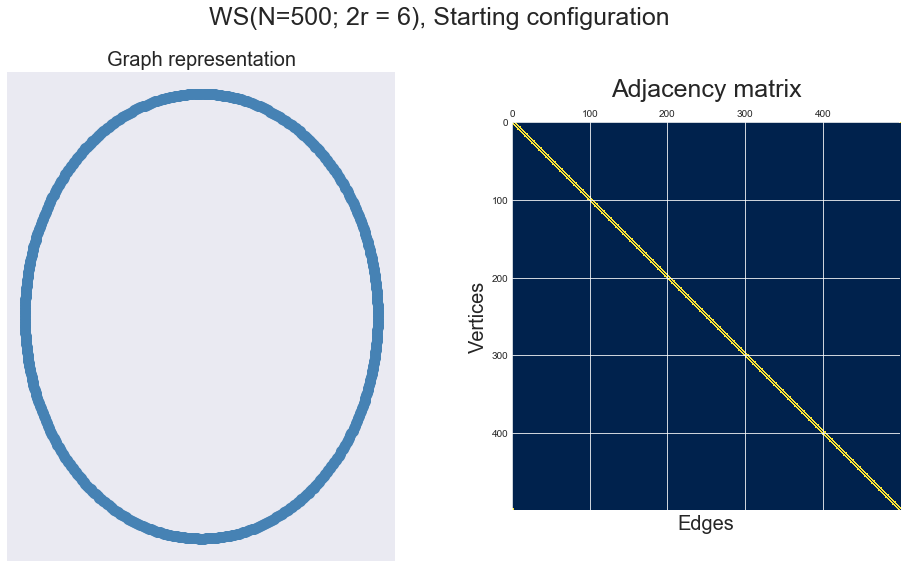

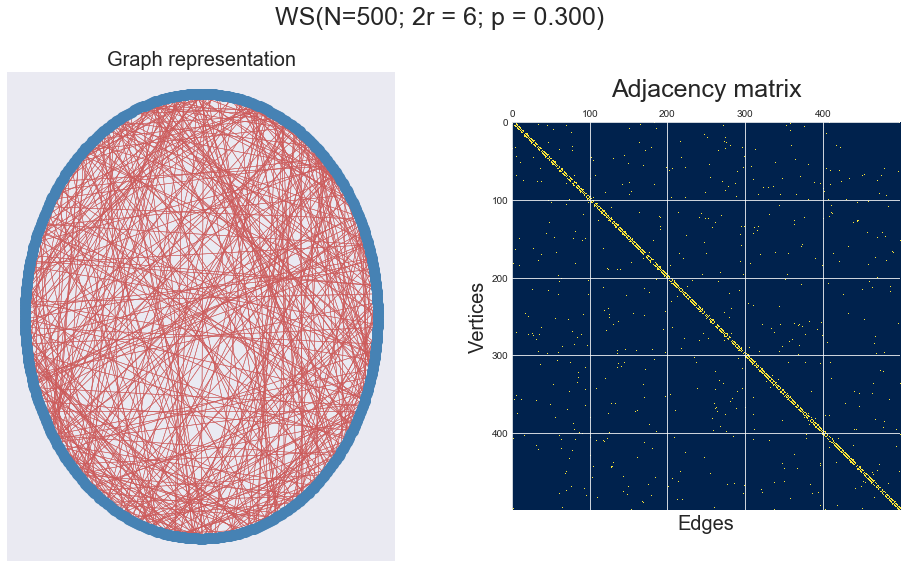

In [72]:
n,r,p=500,3,.3
adj_mat = create_strogatz(n,r,p)

In [73]:
s = adj_mat.sum(axis = 0, skipna = True)
f = sorted(s, reverse = True)

(array([ 1.,  0., 11.,  0.,  0., 24.,  0.,  0., 33.,  0.,  0., 20.,  0.,
         0.,  6.,  0.,  0.,  3.,  0.,  2.]),
 array([ 3.  ,  3.35,  3.7 ,  4.05,  4.4 ,  4.75,  5.1 ,  5.45,  5.8 ,
         6.15,  6.5 ,  6.85,  7.2 ,  7.55,  7.9 ,  8.25,  8.6 ,  8.95,
         9.3 ,  9.65, 10.  ]),
 <a list of 20 Patch objects>)

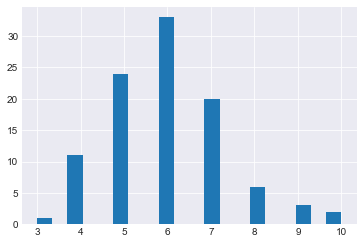

In [66]:
plt.hist(f,bins=20)

In [124]:
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import powerlaw
from scipy.misc import factorial
adj_data = pd.read_csv("Adj_a.csv",header=None)


#def psn(x,lbd):
#    return np.power(lbd,x)*math.exp(-lbd)/factorial(x, exact=False)

[]

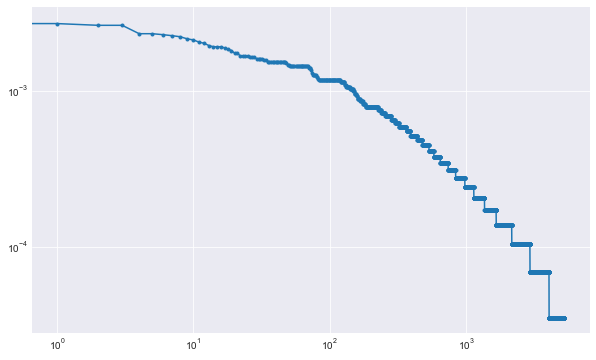

In [42]:
len(adj_data)
plt.figure(figsize=(10,6))
s = adj_data.sum(axis = 0, skipna = True)
f = sorted(s/sum(s), reverse = True)
plt.plot(f,marker='.',ls=None)
x = (np.linspace(0,len(f)-1, len(f)))

#plt.plot(x,poisson.pmf(x, 1, 0))
plt.semilogx()
plt.semilogy()
#plt.xlim(0,10)

In [100]:
sum(f_counts_elements)

500

In [110]:
def normal_distrib(adj_mat):
    s = adj_mat.sum(axis = 0, skipna = True)

    f_unique_elements, f_counts_elements = np.unique(s, return_counts=True)
    observed = f_counts_elements/sum(f_counts_elements)

    p_result = 0
    chi_result = 10000000000000000
    
    mu_norm=-10000
    sigma_norm=0
    for i in range(1,100):
        for j in range(1,100):
            expected = norm.pdf(x,i,j)
            chi_statistic, p_value = chisquare(observed, expected)
            if p_value>p_result and chi_statistic<chi_result:
                mu_norm, sigma_norm = i,j
                p_result, chi_result= p_value, chi_statistic
    plt.plot(x,observed,label="Data")
    plt.plot(x,norm.pdf(x,mu_norm,sigma_norm),label="Normal Distribution")
    plt.legend()
    print(mu_norm,sigma_norm,p_result,chi_result)

In [111]:
chisquare(f_counts_elements, norm.pdf(f_unique_elements),6,)

Power_divergenceResult(statistic=4.658999155199434e+31, pvalue=0.0)

In [115]:
#POISSON
def poiss_distrib(adj_mat):
    s = adj_mat.sum(axis = 0, skipna = True)
    f_unique_elements, f_counts_elements = np.unique(s, return_counts=True)
    observed = f_counts_elements/sum(f_counts_elements)
    x = f_unique_elements
    p_result = 0
    chi_result = 10000000000000000
    mu_poisson=-10
    for i in range(0,100):
        expected = poisson.pmf(x, i, 0)
        chi_statistic, p_value = chisquare(observed, expected)
        if p_value>p_result and chi_statistic<chi_result:
            mu_poisson = i
            p_result, chi_result= p_value, chi_statistic
    print(p_result,chi_result)
    print(mu_poisson)
    plt.plot(x,observed,label="Data")
    plt.plot(x,poisson.pmf(x,mu_poisson,0),label="Poisson Distribution")
    plt.legend()

0.9999365885637842 0.41156330263113966
6


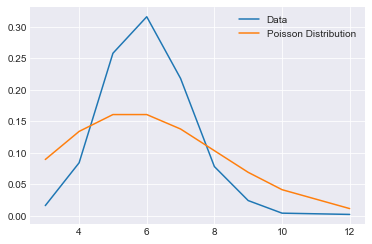

In [118]:
poiss_distrib(adj_mat)

6 2 0.999993920324894 0.22480059563898835


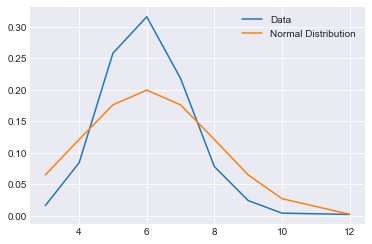

In [114]:
normal_distrib(adj_mat)

In [186]:
def powpow(x,a,b):
    if b<0:
        return a * 1/np.power(x,b)
    else:
        return a * np.power(x,b)


def powlaw(adj_mat):
    s = adj_mat.sum(axis = 0, skipna = True)
    f_unique_elements, f_counts_elements = np.unique(s, return_counts=True)
    observed = f_counts_elements/sum(f_counts_elements)
    x = f_unique_elements
    p_result = 0
    chi_result = 10000000000000000
    for j in range(1,100):
        for i in range(0,100):
            expected = powpow(x, i,j)
            chi_statistic, p_value = chisquare(observed, expected)
            if p_value>p_result and chi_statistic<chi_result:
                a,b = i,j
                p_result, chi_result= p_value, chi_statistic
    print(p_result,chi_result)
    print(a,b)
    plt.plot(x,observed,label="Data")
    plt.plot(x,powpow(x,a,b),label="Power Distribution")
    plt.legend()
    

In [181]:
powlaw(adj_data)

ValueError: Integers to negative integer powers are not allowed.

In [154]:
powpow(2,3)

12

In [190]:
x=[2,3,4,5]
powpow(x,-2,-3)

ValueError: Integers to negative integer powers are not allowed.